# Trial of finetuning

Ref: https://huggingface.co/learn/cookbook/en/fine_tuning_smol_vlm_sft_trl

In [1]:
#!pip install  -U -q transformers==4.46.3 trl==0.12.1 datasets==3.1.0 bitsandbytes==0.45.0 peft==0.13.2 accelerate==1.1.1
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate
# Tested with transformers==4.46.3, trl==0.12.1, datasets==3.1.0, bitsandbytes==0.45.0, peft==0.13.2, accelerate==1.1.1

In [2]:
!pip install -q flash-attn --no-build-isolation

In [3]:
#!pip install -q tensorboard

In [4]:
import time, gc
import torch
from datasets import load_dataset
from PIL import Image
from transformers import Idefics3ForConditionalGeneration, AutoProcessor
from transformers import BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTConfig

In [5]:
image_size = 384

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(DEVICE)
print('bf16 supported:', torch.cuda.is_bf16_supported())
print(torch.__version__)

cuda
bf16 supported: True
2.6.0+cu124


In [7]:
system_message = "You are a Vision Language Model specialized in interpreting visual data from chart images. \
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase. \
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text. \
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."

In [8]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["label"][0]}],
        },
    ]

In [9]:
dataset_id = "HuggingFaceM4/ChartQA"
#train_CQ, eval_CQ, test_CQ = load_dataset(dataset_id, split=["train[:10%]", "val[:10%]", "test[:10%]"])
train_CQ, eval_CQ, test_CQ = load_dataset(dataset_id, split=["train[:10%]", "val[:10%]", "test"])

In [10]:
train_CQ[3]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=314x281>,
 'query': 'What is the sum favourable  value in the year 2014 and 2015?',
 'label': ['95'],
 'human_or_machine': 0}

In [11]:
#### train_CQ[0]['image']

In [12]:
train_CQ = [format_data(sample) for sample in train_CQ]
eval_CQ = [format_data(sample) for sample in eval_CQ]
test_CQ = [format_data(sample) for sample in test_CQ]

In [13]:
train_CQ[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images. Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase. The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text. Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

### Load chartllama using load_dataset

In [14]:
# Data loading from the local drive
dataset_CL = load_dataset('json', data_files=['chartllama_data/box_chart_100examples_simplified_qa.json',
                                           'chartllama_data/candlestick_chart_100examples_simplified_qa.json',
                                           'chartllama_data/funnel_chart_100examples_simplified_qa.json',
                                           'chartllama_data/gantt_chart_100examples_simplified_qa.json',
                                           'chartllama_data/heatmap_chart_100examples_simplified_qa.json',
                                           'chartllama_data/polar_chart_100examples_simplified_qa.json',
                                           'chartllama_data/scatter_chart_100examples_simplified_qa.json'
                                          ]
                      )

In [15]:
#dataset_CL
#dataset_CL['train'][0]['conversations']

In [16]:
def format_CL(sample):
    #print(sample)
    image_path = './chartllama_data/'+ sample['image']
    image_object = Image.open(image_path).resize((image_size, image_size)).convert('RGB')
    question = sample['conversations'][0]['value'].strip('<image>').strip('\n')
    answer = sample['conversations'][1]['value']
    
    output = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_object,
                },
                {
                    "type": "text",
                    "text": question,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": answer}],
        },
    ]
    return output

In [17]:
CL_formated = [format_CL(sample) for sample in dataset_CL['train']]

In [18]:
train_CL = CL_formated[:int(len(CL_formated)*0.8)]
val_CL = CL_formated[int(len(CL_formated)*0.8):]

### Comparsion between train_CQ & train_CL

In [19]:
train_CQ[4]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images. Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase. The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text. Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=420x349>},
   {'type': 'text',
    'text': 'In which year the Mexican governments campaign against drugs traffickers is making 47 percent progress?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '2012'}]}]

In [20]:
train_CL[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images. Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase. The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text. Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=384x384>},
   {'type': 'text', 'text': 'What is the title of the chart?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Analysis of smartphone usage patterns'}]}]

### Load the model & check the performance

In [21]:
#model_id = "HuggingFaceTB/SmolVLM-256M-Base"
#model_id = "HuggingFaceTB/SmolVLM-500M-Base"
model_id = "HuggingFaceTB/SmolVLM-Base"

In [22]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
).to(DEVICE)

processor = AutoProcessor.from_pretrained(model_id)

In [23]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=32, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2], add_generation_prompt=True  # Use the sample without the system message
    )

    image_inputs = []
    image = sample[1]['content'][0]['image']
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_inputs.append([image])
    
    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [24]:
for i in range(10):
    print('pred'+str(i)+':', generate_text_from_sample(model, processor, train_CQ[i]))
    print('true'+str(i)+':', test_CQ[i][2]['content'][0]['text'])

pred0:  2015 Global Attitudes Survey. Q12b.
true0: 14
pred1:  2015-03-28 15:00
true1: 0.57
pred2:  2011
true2: 3
pred3:  2014 2015
true3: No
pred4:  2011 2012 2013 2014 2015 2016 2
true4: 23
pred5:  2011
true5: 6
pred6:  100% 65 59 62 54 45 41 36 35 32
true6: 62
pred7:  100% 65 59 87 62 54 41 45 41 36
true7: Yes
pred8:  11 12 13 14 15 16 17 18 19 20 2
true8: Inspired
pred9:  11 13 19 2011 2012 2013 2014 20
true9: 0.03


In [25]:
def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


### Fine tuning

#### Load quantized model

In [26]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

#### Setup QLoRA and SFT config

In [27]:
# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
    use_dora=True,
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


In [28]:
# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="smolvlm-2B-base-trl-sft-chartllama",
    max_seq_length=256,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_torch_fused",
    bf16=True,
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
)

#### model training (use correct collate_fn)

In [29]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
    processor.tokenizer.additional_special_tokens.index("<image>")
]

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
        image = example[1]["content"][0]["image"]
        if image.mode != "RGB":
            image = image.convert("RGB")
        image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels

    return batch

In [30]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_CL,
    eval_dataset=val_CL,
    data_collator=collate_fn,
    peft_config=peft_config,
    #tokenizer=processor.tokenizer,
)

/home/ricky732/anaconda3/envs/py10_vlm2/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/ricky732/anaconda3/envs/py10_vlm2/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [31]:
start_time = time.time()
trainer.train()
end_time = time.time()
print("Time taken:", (end_time - start_time)/60)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss
25,1.278900
50,0.446700
75,0.137100
100,0.104000
125,0.102200


Time taken: 1045.611521836122


In [32]:
trainer.save_model(training_args.output_dir)

### Testing the Fine-Tuned Model

In [33]:
clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 2.12 GB


In [34]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

In [35]:
adapter_path = "smolvlm-2B-base-trl-sft-chartllama"
model.load_adapter(adapter_path)

In [36]:
test_CQ[12]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images. Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase. The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text. Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=310x358>},
   {'type': 'text', 'text': "What's the lefmost value of bar in China?"}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '17'}]}]

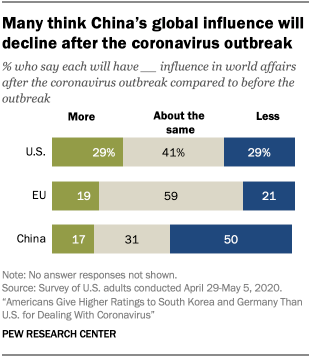

In [37]:
test_CQ[12][1]["content"][0]["image"]

In [38]:
output = generate_text_from_sample(model, processor, test_CQ[12])
output

' 21'

In [39]:
test_CQ[12][2]['content'][0]['text']

'17'

In [40]:
for i in range(100):
    print('pred'+str(i)+':', generate_text_from_sample(model, processor, train_CQ[i]))
    print('true'+str(i)+':', test_CQ[i][2]['content'][0]['text'])

pred0:  No
true0: 14
pred1:  29
true1: 0.57
pred2:  2013
true2: 3
pred3:  53
true3: No
pred4:  2013
true4: 23
pred5:  25
true5: 6
pred6:  1
true6: 62
pred7:  2013
true7: Yes
pred8:  The line with smaller values across all years is the line labeled "Favorable".
true8: Inspired
pred9:  13
true9: 0.03
pred10:  42
true10: 1
pred11:  1
true11: 0.08
pred12:  No
true12: 17
pred13:  No
true13: 21.6
pred14:  Blue
true14: 2
pred15:  53
true15: 2
pred16:  66
true16: 2014
pred17:  No
true17: 2011
pred18:  The first data in orange line is 2003.
true18: 1
pred19:  2013
true19: No
pred20:  The data is a survey asked about U.S. airstrikes against militants in Iraq and Syria.
true20: green line
pred21:  54.5
true21: 2008
pred22:  Blue
true22: 29
pred23:  30.0
true23: 1.216666667
pred24:  73
true24: Yes
pred25:  73
true25: Yes
pred26:  90%
true26: 80
pred27:  1985
true27: 77
pred28:  22.6
true28: 0.6
pred29:  1970-1975
true29: 61
pred30:  2013
true30: 13
pred31:  51
true31: 5
pred32:  41
true32: 24
pred

In [41]:
len(test_CQ)

2500